<a href="https://colab.research.google.com/github/jmassery/fake_news_detector/blob/main/fake_news_detector_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Fake News

In this notebook, I am going to build multiple models to detect the validity of news articles. 

## Problem Definition
Create an NLP model to classify news articles as REAL or FAKE

> Do you trust all the news you hear from social media? All news are not real, right? How will you detect fake news?

## Features
1.  Unnamed: 0 - Identifies the news
2. title - title of the news article
3. text - text within the article
4. label - REAL or FAKE, the predicted attribute

## Preparing the tools

In [1]:
# Confirm access to a GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-214c8a9e-79d0-dc51-ae1f-c1db25bba9fc)


In [2]:
# data analysis and wrangling
import os
import random
import pandas as pd
import numpy as np

# visualization and preprocessing
import matplotlib.pyplot as plt
import string
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# modeling
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

## Get Data

In [3]:
import zipfile

# Download data
!wget https://drive.google.com/u/0/uc?id=1er9NJTLUA3qnRuyhfzuN0XUsoIC4a-_q&export=download

# Unzip downloaded file
zip_ref = zipfile.ZipFile("/content/uc?id=1er9NJTLUA3qnRuyhfzuN0XUsoIC4a-_q", "r")
zip_ref.extractall()
zip_ref.close()

--2021-09-10 18:01:09--  https://drive.google.com/u/0/uc?id=1er9NJTLUA3qnRuyhfzuN0XUsoIC4a-_q
Resolving drive.google.com (drive.google.com)... 108.177.15.138, 108.177.15.139, 108.177.15.113, ...
Connecting to drive.google.com (drive.google.com)|108.177.15.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1hu2hcere84ei004tup6g1c2jeu8l26o/1631296875000/02765671032511850754/*/1er9NJTLUA3qnRuyhfzuN0XUsoIC4a-_q [following]
--2021-09-10 18:01:15--  https://doc-0c-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1hu2hcere84ei004tup6g1c2jeu8l26o/1631296875000/02765671032511850754/*/1er9NJTLUA3qnRuyhfzuN0XUsoIC4a-_q
Resolving doc-0c-0g-docs.googleusercontent.com (doc-0c-0g-docs.googleusercontent.com)... 64.233.166.132, 2a00:1450:400c:c09::84
Connecting to doc-0c-0g-docs.googleusercontent.com (doc-0c-0g-docs.googleusercontent.com)|64

## Visualize data

Since the data is already in a .csv and not a .txt, use pandas for visualization.

In [4]:
news_df = pd.read_csv("news.csv")
news_df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [5]:
# The data looks mixed, but shuffle just to be safe
news_df_shuffled = news_df.sample(frac=1, random_state=42)

In [6]:
# How many examples of each class
news_df_shuffled.label.value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

In [7]:
# Visualize random examples
random_index = random.randint(0, len(news_df)-3)
for row in news_df_shuffled[["text", "label"]][random_index:random_index+3].itertuples():
  _, text, label = row
  print(f"Label: {label}")
  print(f"Text:\n{text}\n")
  print("---\n")

Label: FAKE
Text:
Next Swipe left/right Colin is looking for a songwriting partner Fancy getting into the music business but need a good lyricist to work with? Colin has written songs about dolphins, Giant Haystacks and Hitler.

---

Label: REAL
Text:
The Democratic frontrunner won decisively to take a stranglehold on the race despite all of Sanders’s rallies and celebrity endorsements.

Sanders spent the week sowing the seeds of doubt within Clinton’s coalition—blistering her for her association with Wall Street, holding a series of mega-rallies, collecting a host of celebrity endorsements, and out-spending her by 2-1 on TV ads.



He needed a win, or a very close finish, to maintain the momentum in his unlikely bid to upset Clinton, but the Brooklyn native was defeated by more than 15 points.

“Victory is in sight!” declared Clinton at a New York rally. Staffers near the back of the room hugged each other—visibly relieved that this particularly ugly part of the primary campaign had c

### Split data into training, validation, and test sets

In [8]:
# Change label to be either 0 (FAKE) or 1 (REAL)
news_df_shuffled.label = news_df_shuffled.label.map({'FAKE': 0, 'REAL': 1}).astype(int)

news_df_shuffled.head()

,Unnamed: 0,title,text,label
1357,9957,"American Dream, Revisited",Will Trump pull a Brexit times ten? What would...,0
2080,7596,Clintons Are Under Multiple FBI Investigations...,Clintons Are Under Multiple FBI Investigations...,0
2718,8905,The FBI Can’t Actually Investigate a Candidate...,Dispatches from Eric Zuesse This piece is cros...,0
812,8752,Confirmed: Public overwhelmingly (10-to-1) say...,Print \n[Ed. – Every now and then the facade c...,0
4886,7804,Nanny In Jail After Force Feeding Baby To Death,Nanny In Jail After Force Feeding Baby To Deat...,0


In [9]:
# Create a test and training split
split_size = int(0.8 * len(news_df_shuffled))

news_train_df = news_df_shuffled[:split_size]
news_test_df = news_df_shuffled[split_size:]

len(news_train_df), len(news_test_df)

(5068, 1267)

In [10]:
test_text = news_test_df["text"].to_numpy()
test_labels = news_test_df["label"].to_numpy()

In [11]:
# Split training data in to train and validaiton sets
train_text, val_text, train_labels, val_labels = train_test_split(news_train_df["text"].to_numpy(),
                                                                  news_train_df["label"].to_numpy(),
                                                                  test_size=0.2,
                                                                  random_state=42)

In [12]:
# Check the lengths
len(train_text), len(val_text), len(train_labels), len(val_labels)

(4054, 1014, 4054, 1014)

In [13]:
# Check the first few samples
train_text[:3], train_labels[:3]

(array(['opednews.com - Advertisement - \nI have suggested elsewhere that if we want a better future we will have to create it out of whole cloth and intend that it be \'for the highest and best good for all concerned and the planet\'. \nMost of us know that two things cannot occupy the same space at the same time. The time, space thing that is our planetary reality is occupied by dark, evil, powerful forces with no intention of moving aside to accommodate positive outcomes. \nCarl Jung has noted that "the opposite of love is not hate, it is power". I get this. Love nourishes and empowers the object of its attention, power seeks dominion over what it notices, is destructive. We cannot confront this power and it would be karmically harmful to do so resulting in no change. \nSo, the existent power, in play for 300,000 years, must \'start\' to break down before change is possible, to allow space for that change. If we want to be in control of that change we must be the dominate unified co

## Convert text into numbers

### Text vectorization

In [14]:
text_vectorizer = TextVectorization()

# Average number of tokens in training articles
round(sum([len(i.split()) for i in train_text])/len(train_text))

786

In [15]:
# Fit text_vectorizer
text_vectorizer.adapt(train_text)

In [16]:
# Check vectorizer is working properly
sample = "This is real fake news!"
text_vectorizer([sample])

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[  20,    9,  297, 3319,  122]])>

In [17]:
random_article = random.choice(train_text)
print(f"Original text:\n {random_article}\
        \n\nVectorized version:")
text_vectorizer([random_article])

Original text:
 Next Swipe left/right Vine 2013-2016: celebrate the life and death of an app with these 12 clips Sad news for fans of six second videos – Twitter has announced it will be closing Vine , the app it bought in 2013. Let’s say goodbye by looking back at 12 of the most important Vines ever made.
1. This dog, drifting a car in the snow. 
2. The time George Osborne was a toddler who has just been on gas at the dentist. 
3. This army of screaming ducks 
4. Leonardo DiCaprio getting scared by Lady Gaga 
5. This kid pretending he likes the avocado he’s been given. 
6. Limmy tricks Matt Lucas into thinking he’s posing for a photo. 
7. The last 6 seconds of “Rabbit” by Chas and Dave looped. 
8. This dancing robot, set to Toto’s “Africa”. 
9. This encounter with a rotating foam arm. 
10. The struggle faced by Jay Z’s accountant. 
11. This dog riding a scooter. 
12. Another dog, this time helping out on “Seven Nation Army” by The White Stripes 
But let’s not get too sentimental – Vin

<tf.Tensor: shape=(1, 211), dtype=int64, numpy=
array([[  208,  7494,  9590, 18328, 92657,  3938,     2,   285,     5,
          535,     4,    31,  6314,    13,    99,   943,  8850,  3055,
          122,    10,  3047,     4,   731,   386,  1561,    96,   635,
           24,   611,    14,    34,    18,  2667, 18328,     2,  6314,
           14,  3394,     7,   729,  1473,   124, 13803,    19,   574,
          142,    25,   943,     4,     2,    92,   324, 29245,   361,
          147,   389,    20,  3754, 17800,     6,  1552,     7,     2,
         7334,   577,     2,    86,   519, 30990,    16,     6, 25247,
           32,    24,    73,    44,    11,  1500,    25,     2, 43593,
          676,    20,   870,     4,  5420, 12563,   768, 17522, 21448,
          456,  3476,    19,  1976, 14619,   687,    20,  4383,  5594,
           15,  2920,     2, 19716,   404,    44,   345,  1140, 71830,
         5653,  2368,  9003,    80,  1162,   404,  6825,    10,     6,
         1592,  1084,     2, 

In [18]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()

print(f"Total number of unique words in vocab: {len(words_in_vocab)}")
print(f"Top 10 words: {words_in_vocab[:10]}")
print(f"Least used words: {words_in_vocab[-10:]}")

Total number of unique words in vocab: 93531
Top 10 words: ['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'in', 'that', 'is']
Least used words: ['0026', '002', '0008s', '0007s', '0005s', '0004s', '0002', '00006', '00001400', '0000000031']


### Embedding using an Embedding Layer

In [19]:
embedding = layers.Embedding(input_dim=len(words_in_vocab),
                             output_dim=128)
embedding

In [20]:
# Check embedding layer
random_article = random.choice(train_text)
print(f"Original text:\n {random_article}\
        \n\nEmbedded version:")

# Embed the random article
embedded_article = embedding(text_vectorizer([random_article]))
embedded_article

Original text:
 New Jersey Gov. Chris Christie roared into Sunday after a fierce debate performance hours earlier in which he slowed rising, fellow GOP presidential candidate Sen. Marco Rubio, with the New Hampshire primary ahead.

“He’s a good guy, but he’s just not ready to be president,” Christie told “Fox News Sunday,” after attacking Rubio for his inexperience in running government. “I felt justified because I’ve been saying this for a long time.”

Christie is one of three GOP candidates with governor experience competing with Rubio for the so-called “Republican establishment” vote and trying to stay alive in the race, with insurgents Donald Trump and Texas Sen. Ted Cruz also in the top tier.

“I am tested and prepared and ready,” said Christie, arguing that Barack Obama becoming president as a one-term senator, like Rubio, has been a disaster for the country.

“We don’t need another on-the-job training,” he said. “I’m glad the American people saw (Rubio’s debate performance) befo

<tf.Tensor: shape=(1, 503, 128), dtype=float32, numpy=
array([[[-0.02380004,  0.0176409 ,  0.01749775, ...,  0.00816809,
          0.00683901, -0.01987863],
        [-0.03109795,  0.03586889, -0.00236143, ...,  0.03289516,
         -0.03250984,  0.01398933],
        [-0.00217841, -0.03175209, -0.03071915, ..., -0.04404483,
         -0.0293336 , -0.04105824],
        ...,
        [-0.03212012,  0.0236612 ,  0.04693692, ...,  0.00023953,
         -0.01325717,  0.00295817],
        [ 0.03710547,  0.02305261,  0.01592691, ...,  0.02493706,
          0.03403156,  0.04831208],
        [-0.04003122, -0.0164356 ,  0.0384514 , ..., -0.04260547,
          0.04905072,  0.04646161]]], dtype=float32)>

## Modelling Experiments 

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrainedd Feature Extractor

### Helper functions and variables

In [21]:
# Evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall, and f1 score of a binary classification model.
  """

  # Calculate accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  # Calculate precision, recall, and f1-score using 'weighted' average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  
  return model_results


# Create a TensorBoard callback instand to store log files.
import datetime
SAVE_DIR = "model_logs"

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

### Model 0: Getting a baseline

Create a baseline using Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert words into numbers.

In [22]:
# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

# Fit pipeline to training data
model_0.fit(train_text, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [23]:
# Evaluate baseline model
baseline_score = model_0.score(val_text, val_labels)
print(f"Baseline accuracy: {baseline_score*100:.2f}%")

Baseline accuracy: 80.97%


In [24]:
# Make predictions
baseline_preds = model_0.predict(test_text)
baseline_preds[:20]

array([1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1])

In [25]:
# Calculate results
baseline_results = calculate_results(test_labels, baseline_preds)
baseline_results

{'accuracy': 80.18942383583267,
 'f1': 0.7936290700224626,
 'precision': 0.8477118498688998,
 'recall': 0.8018942383583267}

### Model 1: Simple dense model

Build a simple dense model using the Functional API

In [26]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding (x)
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [27]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         11971968  
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 11,972,097
Trainable params: 11,972,097
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Compile
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit
model_1_history = model_1.fit(train_text,
                              train_labels,
                              epochs=10,
                              validation_data=(val_text, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, model_1.name)])

Saving TensorBoard log files to: model_logs/model_1_dense/20210910-180128
Epoch 1/10
127/127 [==============================] - 7s 35ms/step - loss: 0.6829 - accuracy: 0.5853 - val_loss: 0.6689 - val_accuracy: 0.6371
Epoch 2/10
127/127 [==============================] - 4s 28ms/step - loss: 0.6574 - accuracy: 0.6411 - val_loss: 0.6392 - val_accuracy: 0.7032
Epoch 3/10
127/127 [==============================] - 4s 28ms/step - loss: 0.6194 - accuracy: 0.7124 - val_loss: 0.5866 - val_accuracy: 0.7673
Epoch 4/10
127/127 [==============================] - 4s 29ms/step - loss: 0.5670 - accuracy: 0.7718 - val_loss: 0.5274 - val_accuracy: 0.8205
Epoch 5/10
127/127 [==============================] - 4s 28ms/step - loss: 0.5078 - accuracy: 0.8081 - val_loss: 0.4737 - val_accuracy: 0.8235
Epoch 6/10
127/127 [==============================] - 4s 28ms/step - loss: 0.4591 - accuracy: 0.8397 - val_loss: 0.4305 - val_accuracy: 0.8412
Epoch 7/10
127/127 [==============================] - 4s 28ms/step -

In [29]:
# Evaluate
model_1.evaluate(val_text, val_labels)

32/32 [==============================] - 0s 10ms/step - loss: 0.3283 - accuracy: 0.8738


[0.3283116817474365, 0.8737672567367554]

In [30]:
# Make predictions
model_1_pred_probs = model_1.predict(test_text)
model_1_pred_probs.shape

(1267, 1)

In [31]:
model_1_pred_probs[:10]

array([[0.2430876 ],
       [0.07874929],
       [0.97227955],
       [0.9255234 ],
       [0.24667652],
       [0.1217082 ],
       [0.08622684],
       [0.42647332],
       [0.23756063],
       [0.9200555 ]], dtype=float32)

In [32]:
# Convert prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 1., 0., 0., 0., 0., 0., 1.], dtype=float32)>

In [33]:
# Calculate results
model_1_results = calculate_results(test_labels, model_1_preds)
model_1_results

{'accuracy': 84.92501973164957,
 'f1': 0.8480950459469747,
 'precision': 0.8662028149299428,
 'recall': 0.8492501973164956}

### Model 2: Long Short Term Memory (LSTM)

In [34]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [35]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         11971968  
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [36]:
# Compile
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit
model_2_history = model_2.fit(train_text,
                              train_labels,
                              epochs=10,
                              validation_data=(val_text, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, model_2.name)])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20210910-180211
Epoch 1/10
127/127 [==============================] - 109s 818ms/step - loss: 0.6883 - accuracy: 0.5079 - val_loss: 0.6866 - val_accuracy: 0.5207
Epoch 2/10
127/127 [==============================] - 100s 783ms/step - loss: 0.4541 - accuracy: 0.8078 - val_loss: 0.4228 - val_accuracy: 0.8442
Epoch 3/10
127/127 [==============================] - 98s 775ms/step - loss: 0.4907 - accuracy: 0.7595 - val_loss: 0.6653 - val_accuracy: 0.5582
Epoch 4/10
127/127 [==============================] - 98s 775ms/step - loss: 0.4420 - accuracy: 0.8214 - val_loss: 0.4660 - val_accuracy: 0.8116
Epoch 5/10
127/127 [==============================] - 99s 779ms/step - loss: 0.6149 - accuracy: 0.5972 - val_loss: 0.6928 - val_accuracy: 0.5168
Epoch 6/10
127/127 [==============================] - 102s 804ms/step - loss: 0.6946 - accuracy: 0.4998 - val_loss: 0.6925 - val_accuracy: 0.5148
Epoch 7/10
127/127 [==============================] - 

In [37]:
# Evaluate
model_2.evaluate(val_text, val_labels)

32/32 [==============================] - 9s 275ms/step - loss: 0.6923 - accuracy: 0.4961


[0.6922860145568848, 0.4960552155971527]

In [38]:
# Make predictions
model_2_pred_probs = model_2.predict(test_text)
model_2_pred_probs[:10]

array([[0.5281023 ],
       [0.20972204],
       [0.5281023 ],
       [0.5281023 ],
       [0.5281023 ],
       [0.5281023 ],
       [0.5281023 ],
       [0.5281023 ],
       [0.5281023 ],
       [0.5281023 ]], dtype=float32)

In [39]:
# Convert pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [40]:
# Calculate results
model_2_results = calculate_results(test_labels, model_2_preds)
model_2_results

{'accuracy': 52.09155485398579,
 'f1': 0.3673122158072158,
 'precision': 0.6133566732659298,
 'recall': 0.5209155485398579}

### Model 3: GRU

Build an RNN using GRU

In [41]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [42]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         11971968  
_________________________________________________________________
gru (GRU)                    (None, None, 64)          37248     
_________________________________________________________________
gru_1 (GRU)                  (None, None, 64)          24960     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 64)          

In [43]:
# Compile
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit
model_3_history = model_3.fit(train_text,
                              train_labels,
                              epochs=5,
                              validation_data=(val_text, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, model_3.name)])

Saving TensorBoard log files to: model_logs/model_3_GRU/20210910-182251
Epoch 1/5
127/127 [==============================] - 201s 2s/step - loss: 0.3242 - accuracy: 0.8781 - val_loss: 0.3070 - val_accuracy: 0.8994
Epoch 2/5
127/127 [==============================] - 198s 2s/step - loss: 0.2306 - accuracy: 0.9280 - val_loss: 0.2996 - val_accuracy: 0.9024
Epoch 3/5
127/127 [==============================] - 194s 2s/step - loss: 0.1386 - accuracy: 0.9605 - val_loss: 0.2863 - val_accuracy: 0.9122
Epoch 4/5
127/127 [==============================] - 195s 2s/step - loss: 0.1529 - accuracy: 0.9598 - val_loss: 0.3752 - val_accuracy: 0.8994
Epoch 5/5
127/127 [==============================] - 196s 2s/step - loss: 0.0810 - accuracy: 0.9776 - val_loss: 0.4049 - val_accuracy: 0.9103


In [44]:
# Evaluate
model_3.evaluate(val_text, val_labels)

32/32 [==============================] - 20s 628ms/step - loss: 0.4049 - accuracy: 0.9103


[0.40488648414611816, 0.9102563858032227]

In [45]:
# Make predictions
model_3_pred_probs = model_3.predict(test_text)
model_3_pred_probs[:10]

array([[1.06724734e-07],
       [2.97259217e-10],
       [9.99952912e-01],
       [9.99979019e-01],
       [2.05062353e-03],
       [8.38410358e-07],
       [3.76580367e-09],
       [1.24822269e-04],
       [1.85560639e-05],
       [9.99270737e-01]], dtype=float32)

In [46]:
# convert pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 1., 0., 0., 0., 0., 0., 1.], dtype=float32)>

In [47]:
# Calculate results
model_3_results = calculate_results(test_labels, model_3_preds)
model_3_results

{'accuracy': 90.21310181531176,
 'f1': 0.9021499291142007,
 'precision': 0.9022812535476072,
 'recall': 0.9021310181531176}

### Model 4: Bidrectional RNN

In [49]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [50]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         11971968  
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 12,169,729
Trainable params: 12,169,729
Non-trainable params: 0
_________________________________

In [52]:
# Compile
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit
model_4_history = model_4.fit(train_text,
                              train_labels,
                              epochs=10,
                              validation_data=(val_text, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, model_4.name)])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20210910-185659
Epoch 1/10
127/127 [==============================] - 209s 2s/step - loss: 0.2115 - accuracy: 0.9216 - val_loss: 0.3079 - val_accuracy: 0.8895
Epoch 2/10
127/127 [==============================] - 197s 2s/step - loss: 0.1314 - accuracy: 0.9558 - val_loss: 0.2364 - val_accuracy: 0.9152
Epoch 3/10
127/127 [==============================] - 201s 2s/step - loss: 0.0688 - accuracy: 0.9753 - val_loss: 0.2065 - val_accuracy: 0.9339
Epoch 4/10
127/127 [==============================] - 202s 2s/step - loss: 0.0150 - accuracy: 0.9958 - val_loss: 0.2511 - val_accuracy: 0.9310
Epoch 5/10
127/127 [==============================] - 202s 2s/step - loss: 0.0175 - accuracy: 0.9933 - val_loss: 0.2573 - val_accuracy: 0.9408
Epoch 6/10
127/127 [==============================] - 205s 2s/step - loss: 0.0559 - accuracy: 0.9805 - val_loss: 0.2072 - val_accuracy: 0.9310
Epoch 7/10
127/127 [==============================] - 205s 2

In [53]:
# Evaluate
model_4.evaluate(val_text, val_labels)

32/32 [==============================] - 18s 558ms/step - loss: 0.2857 - accuracy: 0.9398


[0.2857382595539093, 0.9398422241210938]

In [54]:
# Predict
model_4_pred_probs = model_4.predict(test_text)
model_4_pred_probs[:10]

array([[1.8369472e-03],
       [1.0803802e-04],
       [2.1726872e-01],
       [9.9976021e-01],
       [2.6254705e-04],
       [1.6407511e-04],
       [9.4684155e-04],
       [9.9684036e-01],
       [3.5865422e-04],
       [9.9978393e-01]], dtype=float32)

In [55]:
# convert pred probs to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 0., 0., 1., 0., 1.], dtype=float32)>

In [66]:
# Calculate results
model_4_results = calculate_results(test_labels, model_4_preds)
model_4_results

{'accuracy': 91.4759273875296,
 'f1': 0.9146943414553974,
 'precision': 0.9150869218850611,
 'recall': 0.914759273875296}

### Model 5: Conv1D

In [58]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [59]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         11971968  
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          41024     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 12,013,057
Trainable params: 12,013,057
Non-trainable params: 0
________________________________________

In [65]:
# Compile
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit
model_5_history = model_5.fit(train_text,
                              train_labels,
                              epochs=10,
                              validation_data=(val_text, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, model_5.name)])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20210910-193612
Epoch 1/10
127/127 [==============================] - 50s 294ms/step - loss: 0.3264 - accuracy: 0.8920 - val_loss: 0.2657 - val_accuracy: 0.9112
Epoch 2/10
127/127 [==============================] - 17s 133ms/step - loss: 0.1791 - accuracy: 0.9309 - val_loss: 0.2355 - val_accuracy: 0.9142
Epoch 3/10
127/127 [==============================] - 12s 97ms/step - loss: 0.1425 - accuracy: 0.9566 - val_loss: 0.2284 - val_accuracy: 0.9221
Epoch 4/10
127/127 [==============================] - 10s 80ms/step - loss: 0.1110 - accuracy: 0.9628 - val_loss: 0.2332 - val_accuracy: 0.9329
Epoch 5/10
127/127 [==============================] - 11s 89ms/step - loss: 0.0912 - accuracy: 0.9743 - val_loss: 0.2628 - val_accuracy: 0.9320
Epoch 6/10
127/127 [==============================] - 9s 71ms/step - loss: 0.0761 - accuracy: 0.9820 - val_loss: 0.2706 - val_accuracy: 0.9339
Epoch 7/10
127/127 [==============================] - 9s 70m

In [67]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         11971968  
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          41024     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 12,013,057
Trainable params: 12,013,057
Non-trainable params: 0
________________________________________

In [68]:
# Evaluate
model_5.evaluate(val_text, val_labels)

32/32 [==============================] - 1s 21ms/step - loss: 0.3604 - accuracy: 0.9369


[0.36043357849121094, 0.9368836283683777]

In [69]:
# Make predictions
model_5_pred_probs = model_5.predict(test_text)
model_5_pred_probs[:10]

array([[1.2274758e-03],
       [2.0683336e-12],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.1377999e-02],
       [1.2481388e-06],
       [6.6686452e-12],
       [9.2803699e-01],
       [1.5599751e-06],
       [9.9999726e-01]], dtype=float32)

In [70]:
# Convert preds to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 1., 0., 0., 0., 1., 0., 1.], dtype=float32)>

In [71]:
# Calculate results
model_5_results = calculate_results(test_labels, model_5_preds)
model_5_results

{'accuracy': 93.84372533543804,
 'f1': 0.9384517562201082,
 'precision': 0.9386954327053192,
 'recall': 0.9384372533543804}

### Model 6: TensorFlow Hub Pretrained Sentence Encoder

In [73]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        name="USE")


In [74]:
# Use Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(128, activation="relu"),
  layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_6_USE")

In [75]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_8 (Dense)              (None, 128)               65664     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [76]:
# Compile
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit 
model_6_history = model_6.fit(train_text,
                              train_labels,
                              epochs=10,
                              validation_data=(val_text, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, model_6.name)])

Saving TensorBoard log files to: model_logs/model_6_USE/20210910-194959
Epoch 1/10
127/127 [==============================] - 29s 208ms/step - loss: 0.4733 - accuracy: 0.8091 - val_loss: 0.3386 - val_accuracy: 0.8590
Epoch 2/10
127/127 [==============================] - 24s 192ms/step - loss: 0.3158 - accuracy: 0.8688 - val_loss: 0.3036 - val_accuracy: 0.8757
Epoch 3/10
127/127 [==============================] - 25s 192ms/step - loss: 0.2800 - accuracy: 0.8851 - val_loss: 0.2864 - val_accuracy: 0.8826
Epoch 4/10
127/127 [==============================] - 25s 197ms/step - loss: 0.2626 - accuracy: 0.8934 - val_loss: 0.2790 - val_accuracy: 0.8807
Epoch 5/10
127/127 [==============================] - 25s 199ms/step - loss: 0.2543 - accuracy: 0.8962 - val_loss: 0.2764 - val_accuracy: 0.8807
Epoch 6/10
127/127 [==============================] - 24s 192ms/step - loss: 0.2430 - accuracy: 0.8996 - val_loss: 0.2863 - val_accuracy: 0.8856
Epoch 7/10
127/127 [==============================] - 25s 

In [77]:
# Evaluate
model_6.evaluate(val_text, val_labels)

32/32 [==============================] - 4s 136ms/step - loss: 0.2679 - accuracy: 0.8856


[0.26793143153190613, 0.8856015801429749]

In [78]:
# Make predictions
model_6_pred_probs = model_6.predict(test_text)
model_6_pred_probs[:10]

array([[5.8195770e-01],
       [5.9901619e-01],
       [4.2517787e-01],
       [9.9965727e-01],
       [3.8975500e-02],
       [3.4103677e-02],
       [3.3334628e-02],
       [6.8482614e-01],
       [6.9701101e-04],
       [9.5018762e-01]], dtype=float32)

In [79]:
# Convert preds to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1.], dtype=float32)>

In [80]:
# Calculate results
model_6_results = calculate_results(test_labels, model_6_preds)
model_6_results

{'accuracy': 88.39779005524862,
 'f1': 0.8839748616674193,
 'precision': 0.8839729250619456,
 'recall': 0.8839779005524862}

## Compare model performance

In [81]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm":  model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,80.189424,0.847712,0.801894,0.793629
1_simple_dense,84.925020,0.866203,0.849250,0.848095
2_lstm,52.091555,0.613357,0.520916,0.367312
3_gru,90.213102,0.902281,0.902131,0.902150
4_bidirectional,91.475927,0.915087,0.914759,0.914694
5_conv1d,93.843725,0.938695,0.938437,0.938452
6_tf_hub_use_encoder,88.397790,0.883973,0.883978,0.883975


In [82]:
# Match accuracy to other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

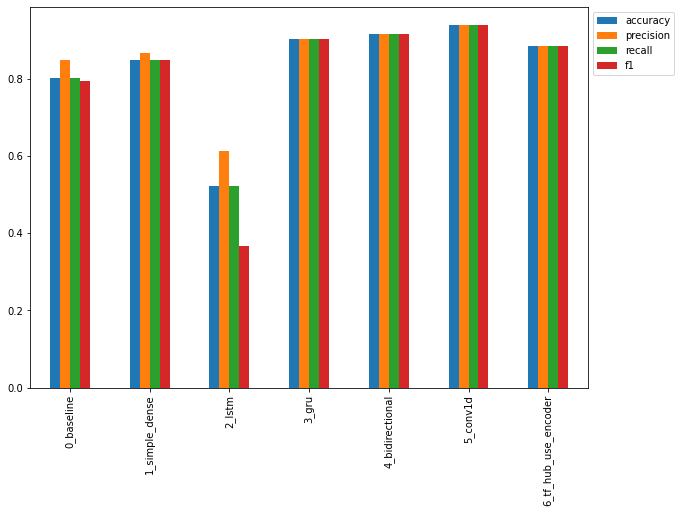

In [84]:
# Plot and compare results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

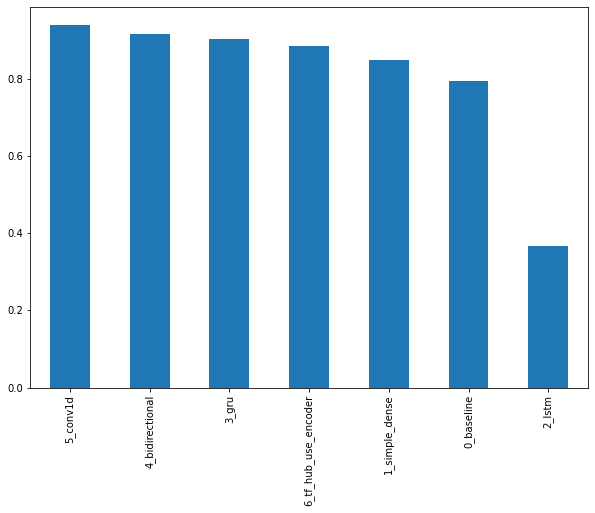

In [86]:
# Sort by f1
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7));